# 305to320 (1-15 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov1-15.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_305to320']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_305to320'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  969


# Feature Correlation

In [ ]:
corr = X.corr()
sns.heatmap(corr)

In [ ]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

In [ ]:
len(pairs)
len(set(pairs))

In [ ]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 969 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9993358639695914


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  3.401419753694646


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


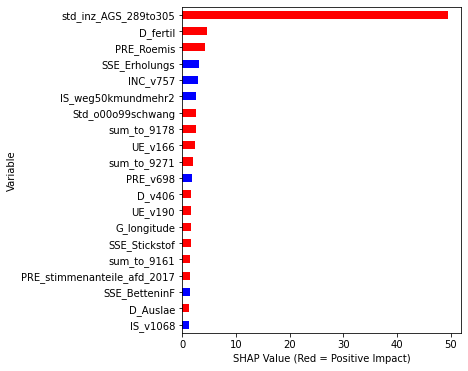

In [7]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

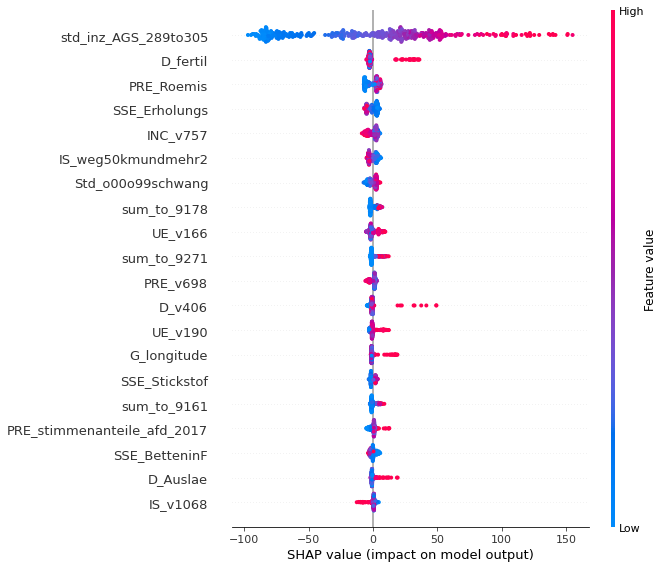

In [8]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [9]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [10]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.997350045532488


In [11]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  6.794396923439103


# Compare top 10 features of both Models

In [12]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_289to305', 'D_fertil', 'PRE_Roemis', 'SSE_Erholungs', 'INC_v757', 'IS_weg50kmundmehr2', 'Std_o00o99schwang', 'sum_to_9178', 'UE_v166', 'sum_to_9271'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_289to305', 'PRE_Roemis', 'SSE_Erholungs', 'INC_v757', 'UE_v166', 'sum_to_9161', 'IS_v1068', 'Std_o00o99schwang', 'IS_weg50kmundmehr2', 'sum_to_9271']


In [13]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_289to305
PRE_Roemis
SSE_Erholungs
INC_v757
IS_weg50kmundmehr2
Std_o00o99schwang
UE_v166
sum_to_9271


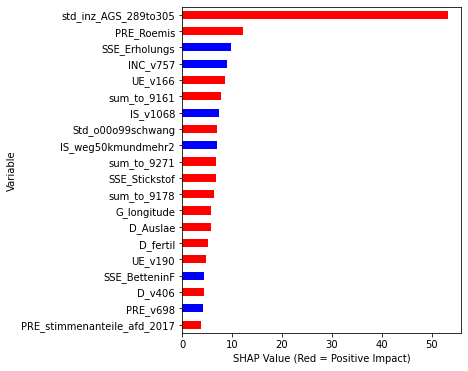

In [14]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

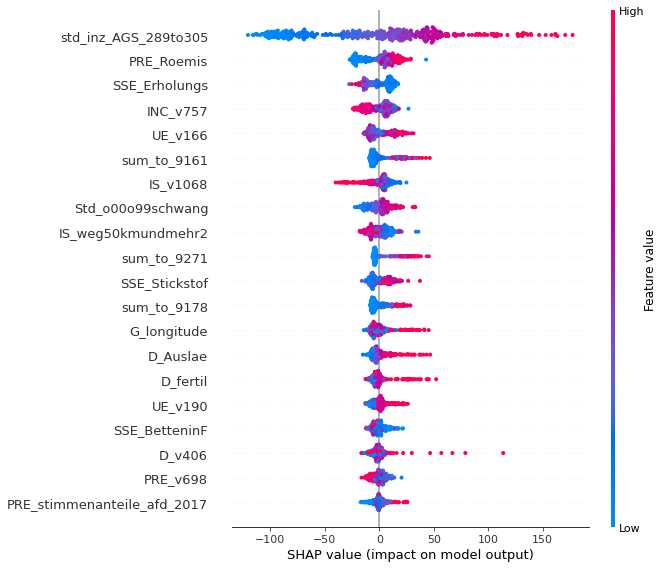

In [15]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9981336693363361
Mean R2 of linReg_modesl with top20 features:  0.7197653719082914
Mean RMSE of CatBoost_models on test sets with top20 features:  68.40908205547417
Mean R2 of CatBoost_models on test sets with top20 features: 0.7128239913554879


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_AGS_289to305,D_fertil,PRE_Roemis,SSE_Erholungs,INC_v757,IS_weg50kmundmehr2,Std_o00o99schwang,sum_to_9178,UE_v166,sum_to_9271,PRE_v698,D_v406,UE_v190,G_longitude,SSE_Stickstof,sum_to_9161,PRE_stimmenanteile_afd_2017,SSE_BetteninF,D_Auslae,IS_v1068
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,196.861191,1.632220,32.242802,70.509460,8.945634,11.484292,128.511276,114.760597,38.296265,35.458855,32.458591,-3.954613,11.710723,9.866997,68.331635,159.645889,13.388280,41.775818,10.034916,1050.970093
std,100.082146,0.134031,24.361443,56.734703,2.964478,3.481254,22.568268,684.609375,7.717491,254.973465,8.857036,4.800081,3.008996,2.026269,27.160891,1470.203491,5.329521,49.309353,5.149191,542.184448
min,21.628151,1.060000,1.700000,14.000000,-14.300000,4.900000,0.000000,0.000000,15.700000,0.000000,0.000000,-18.600000,4.600000,6.083333,21.400000,0.000000,4.900000,0.000000,1.900000,13.000000
25%,124.023865,1.560000,7.900000,39.700001,7.700000,9.000000,119.283463,0.000000,33.299999,0.000000,26.600000,-7.500000,10.600000,8.216666,47.500000,0.000000,9.800000,17.000000,6.200000,582.000000
50%,180.949234,1.650000,29.100000,52.799999,9.000000,10.800000,128.318710,15.000000,38.599998,0.000000,31.700001,-4.200000,12.400000,9.766666,59.200001,12.000000,12.000000,27.000000,9.200000,1056.000000
75%,250.004318,1.720000,52.299999,76.699997,10.700000,13.300000,140.111618,34.000000,43.299999,0.000000,38.200001,-0.300000,13.600000,11.416667,88.199997,28.000000,15.300000,44.700001,13.100000,1458.000000
max,613.031067,1.940000,87.800003,384.600006,24.700001,24.200001,201.136475,10398.000000,68.300003,3506.000000,57.900002,11.100000,20.200001,14.983334,150.699997,25492.000000,35.500000,405.700012,35.000000,2782.000000


In [19]:
pd.DataFrame(Y).describe()

,std_inz_AGS_305to320
count,401.000000
mean,294.754181
std,132.152008
min,51.452923
25%,187.580597
50%,295.148651
75%,375.239899
max,734.390442


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')